In [3]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import pandas as pd
from src.utils import get_generations, get_metrics, get_all, _process_evalharness_results, get_superglue_results, get_empirical_cdf, print_random_examples, plot_superglue_task, get_auc, _get_params_llama, get_good_models, get_watermark_overrides

/home/blockadam/gaussian-watermarking/gaussian_watermarking/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Helper Functions

In [4]:

def _get_rank(param_info):
    """
    Given a key, returns the rank of the model that was dropped
    """
    return int(param_info.split('_r')[-1])
    

def _get_layer(param_info):
    """
    Given a key, returns the layer of the model that was dropped
    """
    return int(param_info.split('_')[0])


def _get_mlp_type(param_info):

    layer = _get_layer(param_info)
    if layer == -1:
        return 'mlp_weight'
    else:
        mlp_type = '_'.join(param_info.split('_')[2:4])
        return mlp_type


def check_match(key, param_data):
    """
    Given a key, check if it matches the desired data to display
    """
    param_info = key[0]
    matches = True
    if 'rank' in param_data.keys():
        if _get_rank(param_info) != param_data['rank']:
            matches = False
    layer = _get_layer(param_info)
    if 'layer' in param_data.keys():
        if param_data['layer'] != layer:
            matches = False
    if 'mlp_type' in param_data.keys() and layer != -1:
        mlp_type = '_'.join(param_info.split('_')[2:4])
        if param_data['mlp_type'] != mlp_type:
            matches = False


    return matches
    
def get_title(param_data):
    """
    Given the parameters, return the title for the plot
    """
    title = ''
    if 'layer' in param_data.keys():
        title += str(param_data['layer'])
    if 'mlp_type' in param_data.keys():
        title += '_' + param_data['mlp_type']
    if 'rank' in param_data.keys():
        title += '_r' + str(param_data['rank'])
    
    if 'gate_up_proj' in title:
        title = title.replace('gate_up_proj', 'mlp_gate_up_proj')
    
    return title

# Getting Data

In [5]:
# parent = './amlt/llama-watermark-lm'

# param = '-1_mlp_weight'


# parent = './amlt/llama-watermark'
# parent = './amlt/08-30-llama-watermark-early'
# parent = './amlt/09-02-lowrank-watermark-lm'
# parent = './amlt/09-02-lowrank-watermark-proj'
# parent = './amlt/09-03-watermark-mistral'
# parent = './amlt/09-03-watermark-mistral-lm'


# parent = './amlt/llama-watermark'
# parent = './amlt/09-02-lowrank-watermark-lm'
# parent = './amlt/09-04-watermark-mistral'
# parent = './amlt/09-04-watermark-mistral-lm'
# parent = './amlt/09-04-watermark-llama'
# parent = './amlt/09-04-watermark-llama-lm'
# parent = './amlt/09-04-mistral-lowrank'


parent = './amlt/09-12-watermark-phi'


generations = get_generations(parent, _get_params=_get_params_llama)
metrics = get_metrics(parent, _get_params=_get_params_llama)


min_prob = 1e-14


param_data = {  
    # 'rank': 0,
    # 'layer': 31,
    # 'mlp_type': 'down_proj'
    # 'mlp_type': 'up_proj'
    # 'mlp_type': 'gate_proj'
    # 'mlp_type': 'gate_up'
    'layer': -1,
    'mlp_type': 'weight'
}
param = get_title(param_data)
print(param)

generations_param = {(_get_rank(key[0]),key[1], _get_mlp_type(key[0])): value for key, value in generations.items() if check_match(key, param_data)}
data_param = {key: get_all(value, min_prob) for key, value in generations_param.items()}
metrics_param = {(_get_rank(key[0]),key[1], _get_mlp_type(key[0])): value for key,value in metrics.items() if check_match(key, param_data)}

unwatermarked_parent = './amlt/09-04-eval-models'
if 'mistral' in parent:
    model = 'Mistral'
    unwatermarked_path = os.path.join(unwatermarked_parent, 'grid_09-04-eval-models_mod_mistralai_Mistral-7B-v0.3')
elif 'Phi' in parent or 'phi' in parent:
    model = 'Phi-3'
    # unwatermarked_path = os.path.join(unwatermarked_parent, 'grid_09-04-eval-models_mod_microsoft_Phi-3-mini-4k-instruct')
    unwatermarked_path = './amlt/09-13-eval-phi.yaml/grid_09-13-eval-phi.yaml_mod_microsoft_Phi-3-mini-4k-instruct'
# elif 'Llama-3' in parent:
elif '09-04-watermark-llama' in parent: # Llama-3
    model = 'Llama-3'
    unwatermarked_path = os.path.join(unwatermarked_parent, 'grid_09-04-eval-models_mod_meta-llama_Meta-Llama-3.1-8B')
else: # Llama-2
    model = 'Llama-2'
    unwatermarked_path = os.path.join(unwatermarked_parent, 'grid_09-04-eval-models_mod_meta-llama_Llama-2-7b-hf')

with open(os.path.join(unwatermarked_path, 'data/eval_results/results.json')) as f:
    unwatermarked_metrics = json.load(f)

unwatermarked_metrics = _process_evalharness_results(unwatermarked_metrics)
metrics_param.update({(0,0): unwatermarked_metrics})


# with open(os.path.join('amlt/unwatermarked_superglue/results.json')) as f:
#     llama_metrics = json.load(f)
# unwatermarked_metrics = _process_evalharness_results(llama_metrics)

# metrics_param.update({(0,0): llama_metrics})


No metrics found for ('-1_mlp_none_ran_0_r0', 3e-05)
-1_weight


# Summary statistics

In [6]:
sig_pval = 0.05
include_gsm8k = False

num_passed = {}
log_probs_diff = {}
superglue_score = {}
superglue_stderr = {}
gsm8k_scores = {}
gsm8k_stderrs = {}


for key, data in data_param.items():
    num_passed[key] = data[data['pvalue'] < sig_pval].shape[0] / data.shape[0]
    log_probs_diff[key] = data['logprob_diff_per_token'].mean()
    
    superglue_score[key] = get_superglue_results(metrics_param[key])[1]
    superglue_stderr[key] = get_superglue_results(metrics_param[key])[2]

    gsm8k_score, gsm8k_stderr = get_superglue_results(metrics_param[key])[-1]
    gsm8k_scores[key] = gsm8k_score
    gsm8k_stderrs[key] = gsm8k_stderr
    
    # try:
        # superglue_score[key] = get_superglue_results(metrics_param[key])[1]
        # superglue_stderr[key] = get_superglue_results(metrics_param[key])[2]

        # gsm8k_score, gsm8k_stderr = get_superglue_results(metrics_param[key])[-1]
        # gsm8k_scores[key] = gsm8k_score
        # gsm8k_stderrs[key] = gsm8k_stderr
    # except:
    #     print(f"No superglue scores available for {key}")
    #     superglue_score[key] = np.nan
    #     superglue_stderr[key] = np.nan
    #     gsm8k_scores[key] = np.nan
    #     gsm8k_stderrs[key] = np.nan
        


print(f"Model: {model}")
param_data = {key:param_data[key] for key in sorted(param_data.keys())}
for key, val in param_data.items():
    print(f"{key}: {val}")
print('#' * 40 + '\n')


# print(param + ' ' + '#'*40 +'\n')

print(f"Significance threshold: {sig_pval:.4f}")
for key in num_passed.keys():
    print(f"Fraction significant generations (var {key[1]}, rank {key[0]}, {key[2]}): {num_passed[key]:.4f}")
print('\n')

# llama_score = np.mean(get_superglue_results(llama_metrics)[1])
# llama_stderr = np.mean(get_superglue_results(llama_metrics)[2])
unwatermarked_score = np.mean(get_superglue_results(unwatermarked_metrics)[1])
unwatermarked_stderr = np.mean(get_superglue_results(unwatermarked_metrics)[2])
print(f"Superglue scores")
# print(f"Llama score: {llama_score:.4f} +/- {llama_stderr:.4f}")
print(f"Unwatermarked score: {unwatermarked_score:.4f} +/- {unwatermarked_stderr:.4f}")
for key in superglue_score.keys():
    if key[1] > 0:
        print(f"SuperGlue score (var {key[1]}, rank {key[0]}, {key[2]}): {np.mean(superglue_score[key]):.4f} +/- {np.mean(superglue_stderr[key]):.4f}")



unwatermarked_gsm8k_score, unwatermarked_gsm8k_stderr = get_superglue_results(unwatermarked_metrics)[-1]

try:
    print(f"\nGSM8k scores")
    print(f"Unwatermarked score: {unwatermarked_gsm8k_score:.4f} +/- {unwatermarked_gsm8k_stderr:.4f}")
    for key in gsm8k_scores.keys():
        if key[1] > 0:
            print(f"GSM8k score (var {key[1]}, rank {key[0]}, {key[2]}): {np.mean(gsm8k_scores[key]):.4f} +/- {np.mean(gsm8k_stderrs[key]):.4f}")

except:
    print("No GSM8k scores available")


print('\n')
for key in log_probs_diff.keys():
    print(f"Mean token logprob difference (var {key[1]}, rank {key[0]}, {key[2]}): {log_probs_diff[key]:.4f}")


Model: Phi-3
layer: -1
mlp_type: weight
########################################

Significance threshold: 0.0500
Fraction significant generations (var 0.0001, rank 0, mlp_weight): 0.9940
Fraction significant generations (var 0.0001, rank 4, mlp_weight): 0.9940
Fraction significant generations (var 0.0003, rank 0, mlp_weight): 0.9980
Fraction significant generations (var 0.0003, rank 16, mlp_weight): 0.9980
Fraction significant generations (var 3e-05, rank 0, mlp_weight): 0.9390
Fraction significant generations (var 3e-05, rank 4, mlp_weight): 0.9350
Fraction significant generations (var 0.0003, rank 4, mlp_weight): 0.9980
Fraction significant generations (var 3e-06, rank 0, mlp_weight): 0.5930
Fraction significant generations (var 0.0001, rank 16, mlp_weight): 0.9900
Fraction significant generations (var 3e-06, rank 4, mlp_weight): 0.5660
Fraction significant generations (var 1e-05, rank 4, mlp_weight): 0.8340
Fraction significant generations (var 1e-05, rank 16, mlp_weight): 0.8350
Fr

# Plotting

AUC (var 3e-06, rank 0, mlp_weight): 0.8675
AUC (var 1e-05, rank 0, mlp_weight): 0.9424


AUC (var 3e-05, rank 0, mlp_weight): 0.9803
AUC (var 0.0001, rank 0, mlp_weight): 0.9967
AUC (var 0.0003, rank 0, mlp_weight): 0.9983
AUC (var 3e-06, rank 4, mlp_weight): 0.8612
AUC (var 1e-05, rank 4, mlp_weight): 0.9454
AUC (var 3e-05, rank 4, mlp_weight): 0.9780
AUC (var 0.0001, rank 4, mlp_weight): 0.9969
AUC (var 0.0003, rank 4, mlp_weight): 0.9983
AUC (var 3e-06, rank 16, mlp_weight): 0.8613
AUC (var 1e-05, rank 16, mlp_weight): 0.9440
AUC (var 3e-05, rank 16, mlp_weight): 0.9806
AUC (var 0.0001, rank 16, mlp_weight): 0.9960
AUC (var 0.0003, rank 16, mlp_weight): 0.9982


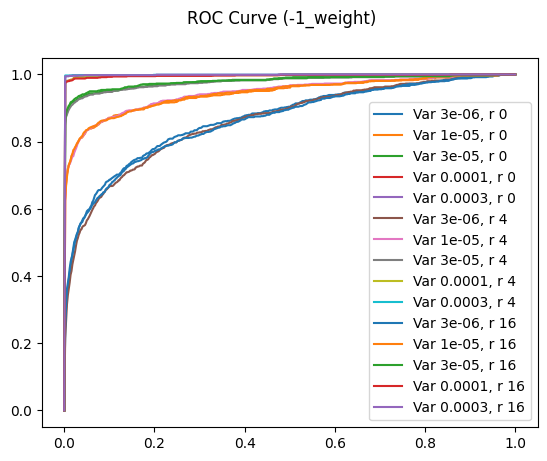

In [7]:
grid_size = 500
fig, ax = plt.subplots()
data_param = {key: data_param[key] for key in sorted(data_param.keys())}
for key, data in data_param.items():
    grid, cdf = get_empirical_cdf(data['pvalue'], grid_size=grid_size)
    auc = get_auc(grid, cdf)
    print(f"AUC (var {key[1]}, rank {key[0]}, {key[2]}): {auc:.4f}")
    ax.plot(grid, cdf, label=f'Var {key[1]}, r {key[0]}')

ax.legend()
fig.suptitle(f'ROC Curve ({param})')
plt.show()

# Superglue Metrics

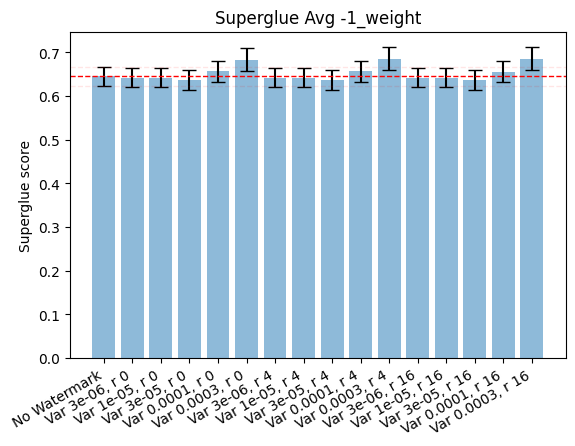

In [8]:
fig, ax  = plt.subplots()

vars, scores, errors = [], [], []


superglue_score = {key: superglue_score[key] for key in sorted(superglue_score.keys())}
vars.append('No Watermark')
scores.append(unwatermarked_score)
errors.append(unwatermarked_stderr)
for key in superglue_score.keys():
    scores.append(np.mean(superglue_score[key]))
    errors.append(np.mean(superglue_stderr[key]))
    vars.append(f'Var {key[1]}, r {key[0]}')

ax.bar(vars, scores, yerr=errors, alpha=0.5, capsize=5)
ax.axhline(unwatermarked_score, label='Llama', linestyle='--', linewidth=1, color='red')
ax.axhline(unwatermarked_score - unwatermarked_stderr, linestyle='--', linewidth=1, color='red', alpha=0.1)
ax.axhline(unwatermarked_score + unwatermarked_stderr, linestyle='--', linewidth=1, color='red', alpha=0.1)


ax.set_ylabel('Superglue score')
ax.set_title(f'Superglue Avg {param}')

fig.autofmt_xdate()
plt.show()

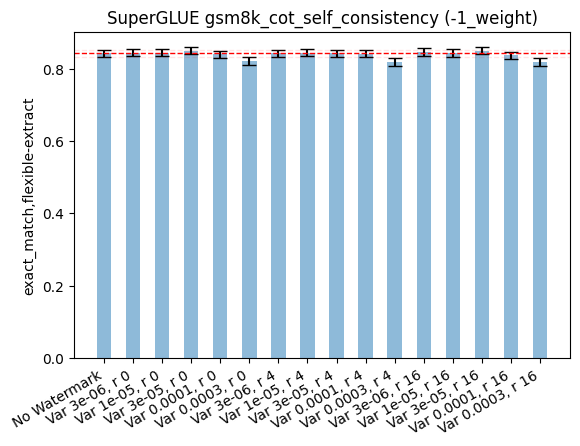

In [9]:
try:
    fig, ax = plot_superglue_task(metrics_param, 'gsm8k', param, include_gsm8k=True)
    plt.show()
except:
    try:
        fig, ax = plot_superglue_task(metrics_param, 'gsm8k_cot_self_consistency', param, include_gsm8k=True)
        plt.show()
    except:
        print(f"No GSM8k scores available for {param}")

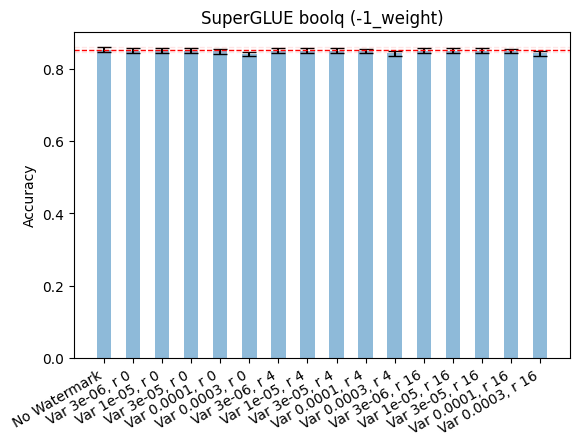

In [10]:
fig, ax = plot_superglue_task(metrics_param, 'boolq', param)
plt.show()

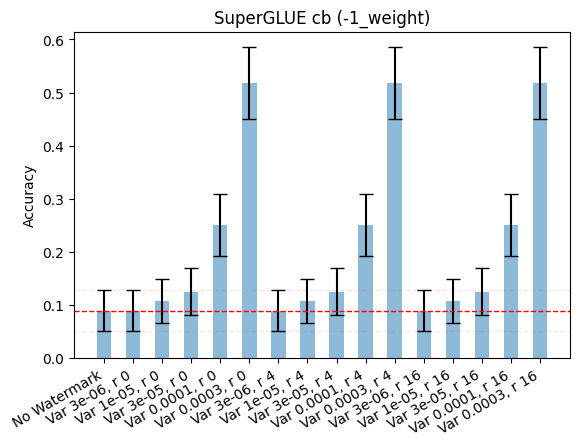

In [11]:
fig, ax = plot_superglue_task(metrics_param, 'cb', param)
plt.show()

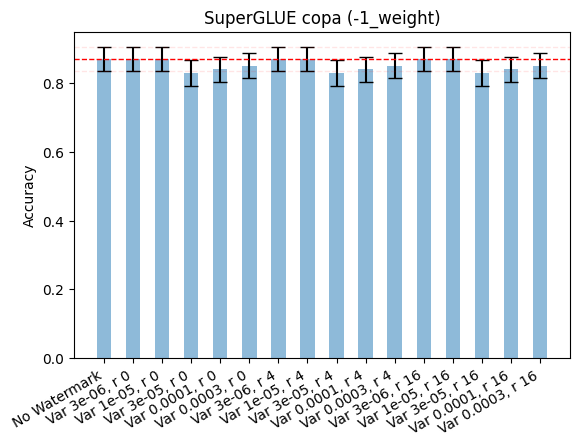

In [12]:
fig, ax = plot_superglue_task(metrics_param, 'copa', param)
plt.show()

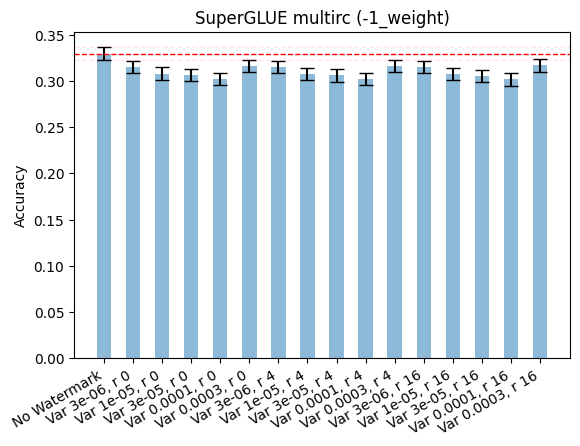

In [13]:
fig, ax = plot_superglue_task(metrics_param, 'multirc', param)
plt.show()

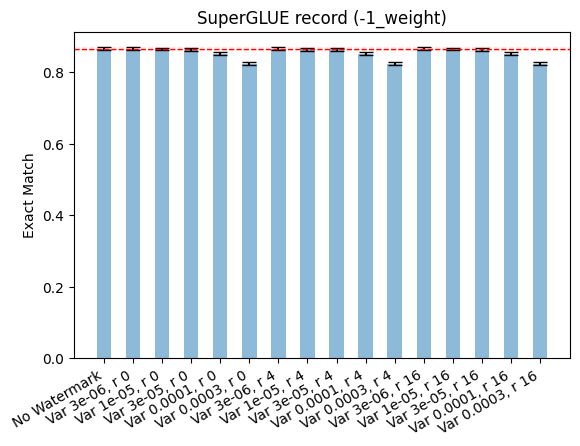

In [14]:
fig, ax = plot_superglue_task(metrics_param, 'record', param)
plt.show()

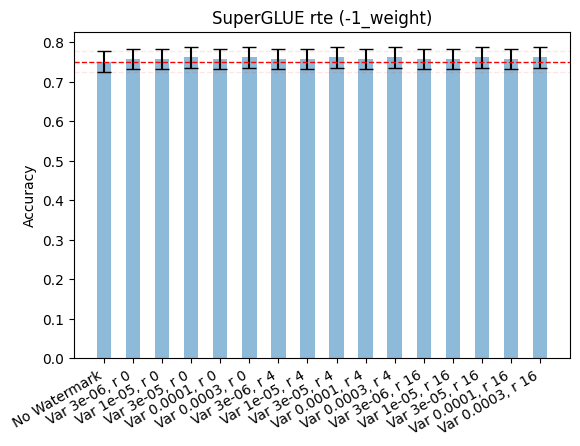

In [15]:
fig, ax = plot_superglue_task(metrics_param, 'rte', param)
plt.show()

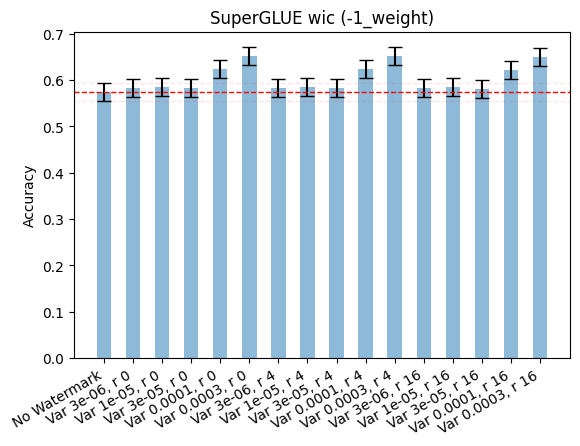

In [16]:
fig, ax = plot_superglue_task(metrics_param, 'wic', param)
plt.show()

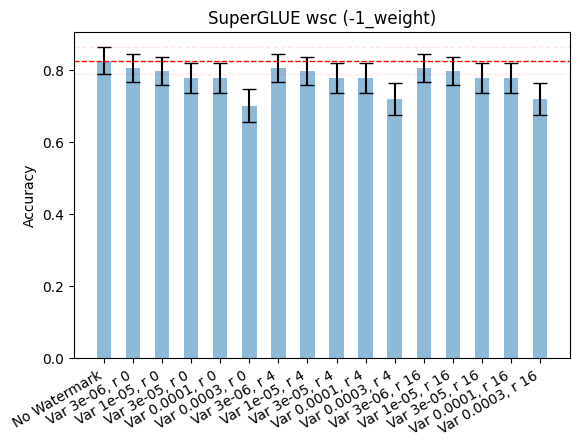

In [17]:
fig, ax = plot_superglue_task(metrics_param, 'wsc', param)
plt.show()

# Extra Plots

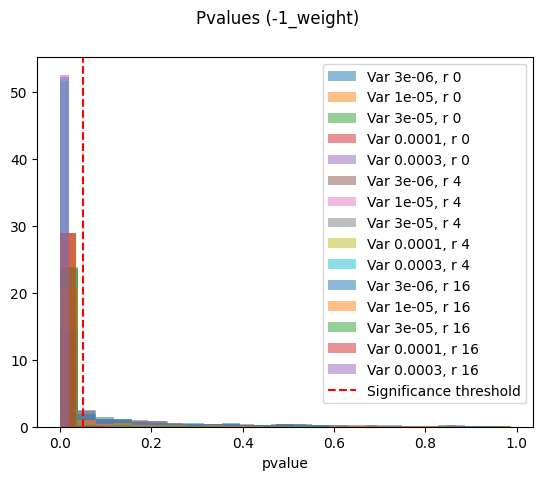

In [18]:
fig, ax  = plt.subplots()

sig_pval = 0.05

bins = 25
alpha = 0.5

for key, data in data_param.items():
    ax.hist(data['pvalue'], density=True, label=f'Var {key[1]}, r {key[0]}', alpha=alpha, bins=bins)

ax.axvline(sig_pval, color='red', label='Significance threshold', linestyle='--') 

ax.set_xlabel('pvalue')
ax.legend()

fig.suptitle(f"Pvalues ({param})")
plt.show()

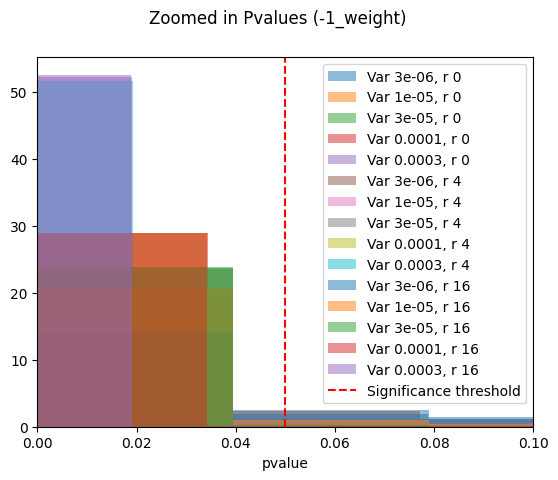

In [19]:
fig, ax  = plt.subplots()

sig_pval = 0.05

bins = 25
alpha = 0.5

for key, data in data_param.items():
    ax.hist(data['pvalue'], density=True, label=f'Var {key[1]}, r {key[0]}', alpha=alpha, bins=bins)

ax.axvline(sig_pval, color='red', label='Significance threshold', linestyle='--') 

ax.set_xlabel('pvalue')
ax.legend()

ax.set_xlim(0, 0.1)

fig.suptitle(f"Zoomed in Pvalues ({param})")
plt.show()

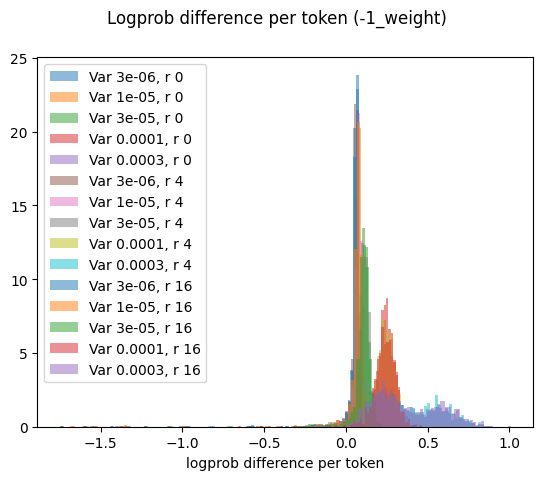

In [20]:
fig, ax = plt.subplots()
bins = 100
alpha = 0.5

for key, data in data_param.items():
    ax.hist(data['logprob_diff_per_token'], density=True, label=f'Var {key[1]}, r {key[0]}', alpha=alpha, bins=bins)
ax.set_xlabel('logprob difference per token')
ax.legend()
fig.suptitle(f"Logprob difference per token ({param})")
plt.show()

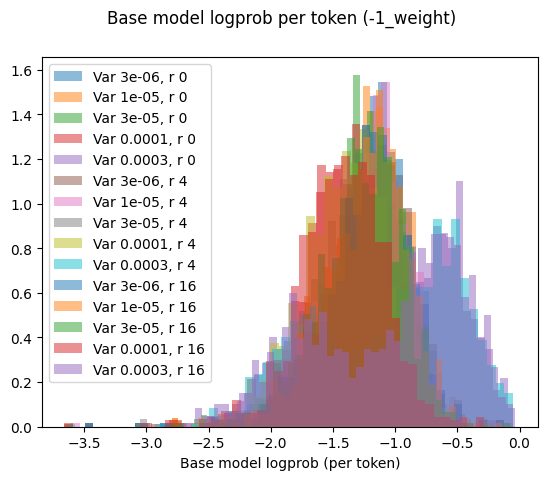

In [21]:
fig, ax = plt.subplots()
bins= 50
alpha = 0.5

for key, data in data_param.items():
    ax.hist(data['base_model_logprob'] / data['length'], density=True, label=f'Var {key[1]}, r {key[0]}', alpha=alpha, bins=bins)


ax.set_xlabel('Base model logprob (per token)')
ax.legend()

fig.suptitle(f"Base model logprob per token ({param})")

plt.show()

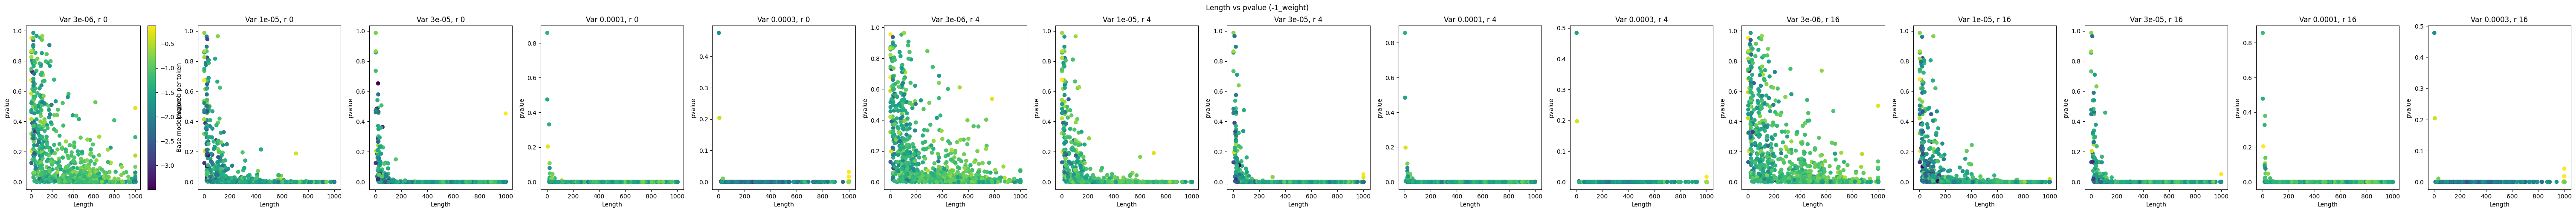

In [22]:
fig, ax = plt.subplots(1,len(data_param), figsize=(2 + 5*len(data_param),5))
scatters = []
for i, (key, data) in enumerate(data_param.items()):
    scatter_i = ax[i].scatter(data['length'], data['pvalue'], c=data['base_model_logprob'] / data['length'], cmap='viridis')
    ax[i].set_xlabel('Length')
    ax[i].set_ylabel('pvalue')
    ax[i].set_title(f'Var {key[1]}, r {key[0]}')
    scatters.append(scatter_i)

cbar = plt.colorbar(scatters[0], ax=ax[0])
cbar.set_label('Base model logprob per token')


fig.suptitle(f"Length vs pvalue ({param})")

plt.show()

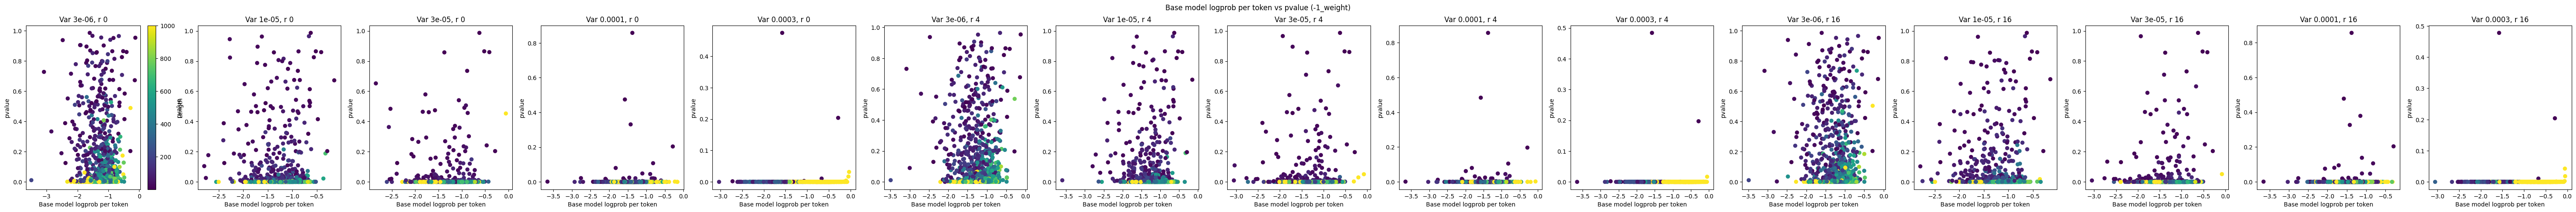

In [23]:
fig, ax = plt.subplots(1,len(data_param), figsize=(2 + 5*len(data_param),5))
scatters = []
for i, (key, data) in enumerate(data_param.items()):
    scatter_i = ax[i].scatter(data['base_model_logprob'] / data['length'], data['pvalue'], c=data['length'], cmap='viridis')
    ax[i].set_xlabel('Base model logprob per token')
    ax[i].set_ylabel('pvalue')
    ax[i].set_title(f'Var {key[1]}, r {key[0]}')
    scatters.append(scatter_i)

cbar = plt.colorbar(scatters[0], ax=ax[0])
cbar.set_label('Length')
fig.suptitle(f"Base model logprob per token vs pvalue ({param})")

plt.show()

# Example text

In [24]:
idxs = None
num_examples = 2
# key = ('31_mlp_down_proj_ran_16_r16', 0.001)
key = ('31_mlp_down_proj_r0', 3e-06)
# key = ('-1_mlp_none_r0', 3e-06)



gen = generations[key]
prompts, responses = [], []
for example in gen:
    prompts.append(example['prompt'])
    responses.append(example['response'])

if idxs is not None:
    assert num_examples <= len(idxs), "Number of examples must be less than or equal to the number of indices"
else:
    idxs = np.random.choice(len(gen), num_examples, replace=False)

for i in range(num_examples):
    idx = idxs[i]
    print(f"({idx})\t" + prompts[idx] + responses[idx] + '\n')

KeyError: ('31_mlp_down_proj_r0', 3e-06)

# Get good models

In [25]:
def get_watermark_overrides(key):
    """
    Given keys output by `get_good_models` returns the override parameter to use to recover this model.
    """
    model_type, param, var = key
    if model_type == 'Mistral':
        model_name = 'mistralai/Mistral-7B-v0.3'
    elif model_type == 'Llama-3':
        model_name = 'meta-llama/Meta-Llama-3.1-8B'
    elif model_type == 'Llama-2':
        model_name = 'meta-llama/Llama-2-7b-hf'
    elif model_type == 'Phi-3':
        model_name = 'microsoft/Phi-3-mini-4k-instruct'
    else:
        raise ValueError("Invalid model type")

    rank = param.split('_')[-1][1:]
    layer = param.split('_')[0]
    mlp_type = param.split('_')[2:-3]
    if len(mlp_type) == 0:
        mlp_type = 'none'
    else:
        mlp_type = '_'.join(mlp_type)

    watermark_param = f"{layer}@@@{mlp_type}@@@weight"

    return '@___@'.join([model_name, rank, watermark_param, str(var)])


In [26]:
# parents = [
#     './amlt/llama-watermark',
#     './amlt/09-04-watermark-mistral',
#     './amlt/09-04-watermark-mistral-lm',
#     './amlt/09-04-watermark-llama',
#     './amlt/09-04-watermark-llama-lm',
#     './amlt/09-04-mistral-lowrank'
# ]
# parents = ['./amlt/llama-watermark']
parents = ['./amlt/09-12-watermark-phi']
# parents = [
#     './amlt/09-04-watermark-mistral',
#     './amlt/09-04-watermark-mistral-lm',
#     './amlt/09-04-watermark-mistral-lowrank',
# ]

# good_models = get_good_models(parents, auc_threshold=0.90, tolerance=-0.001, min_prob=1e-20, grid_size=500, include_gsm8k=True)





good_models = get_good_models(parents, auc_threshold=0.90, tolerance=0.005, min_prob=1e-20, grid_size=500, include_gsm8k=True)

No metrics found for ('-1_mlp_none_ran_0_r0', 3e-05)


In [27]:
print(f"Num good models: {len(good_models)}\n")
overrides  = []
for key in good_models.keys():
    # print(f"{key}: AUC {good_models[key]:.4f}")
    override = get_watermark_overrides(key)
    overrides.append((override, good_models[key]))

sorted_overrides = sorted(overrides, key=lambda x: x[1], reverse=True)
for override, auc in sorted_overrides:
    print(f"{override}: AUC {auc:.4f}")


Num good models: 3

microsoft/Phi-3-mini-4k-instruct@___@16@___@31@@@down_proj@@@weight@___@3e-05: AUC 0.9567
microsoft/Phi-3-mini-4k-instruct@___@4@___@31@@@down_proj@@@weight@___@3e-05: AUC 0.9562
microsoft/Phi-3-mini-4k-instruct@___@0@___@31@@@down_proj@@@weight@___@3e-05: AUC 0.9551


# Getting effect of numtokens

In [28]:
def get_model_key(path):
    """
    Given a path to a directory, returns the key for the dictionary of generations
    """
    try:
        model_name = os.listdir(os.path.join(path, 'models'))[0]
        param_path = os.path.join(path, 'models', model_name, 'params.json')
        with open(param_path, 'r') as f:
            params = json.load(f)
        
        watermark_param_names = params['watermark_param_names']

        layer = int(watermark_param_names[0].split('.')[2])
        mlp_type = watermark_param_names[0].split('.')[4]
        variance = params['variance']
        model_name = params['tokenizer_name']
        rank = params['rank_to_drop']
        return (model_name, layer, mlp_type, variance, rank)
    except:
        print(f"Error with {path}")
        return None

def get_max_tokens(dirname):

    span = re.search('_max_(\d+)', dirname).span()
    return int(dirname[span[0] + 5:span[1]])

def get_generations_num_tokens(parent):

    generations, all_data = {}, {}
    for dirname in os.listdir(parent):

        path = os.path.join(parent, dirname)
        model_key = get_model_key(path)
        if model_key is None:
            continue

        if model_key not in generations.keys():
            generations[model_key] = {}
            all_data[model_key] = {}
        
        num_tokens = get_max_tokens(dirname)
        with open(os.path.join(path, 'generations.json')) as f:
            gens = json.load(f)
        try:
            all_data[model_key][num_tokens] = get_all(gens, min_prob)
            generations[model_key][num_tokens] = gens
        except:
            print(f"Error with {path}")
            

    
    return generations, all_data
        



In [29]:
parent = './amlt/09-06-watermark-numtokens'
generations_tokens, all_data_tokens = get_generations_num_tokens(parent)

Error with ./amlt/09-06-watermark-numtokens/grid_09-06-watermark-numtokens_max_50_wat_meta-llama_Llama-2-7b-hf_____0_____-1___none___weight_____3e-06
Error with ./amlt/09-06-watermark-numtokens/grid_09-06-watermark-numtokens_max_300_wat_meta-llama_Llama-2-7b-hf_____0_____-1___none___weight_____3e-06
Error with ./amlt/09-06-watermark-numtokens/grid_09-06-watermark-numtokens_max_500_wat_meta-llama_Llama-2-7b-hf_____0_____-1___none___weight_____3e-06
Error with ./amlt/09-06-watermark-numtokens/grid_09-06-watermark-numtokens_max_700_wat_meta-llama_Llama-2-7b-hf_____0_____-1___none___weight_____3e-06
Error with ./amlt/09-06-watermark-numtokens/grid_09-06-watermark-numtokens_max_20_wat_meta-llama_Llama-2-7b-hf_____0_____-1___none___weight_____3e-06
Error with ./amlt/09-06-watermark-numtokens/grid_09-06-watermark-numtokens_max_100_wat_meta-llama_Llama-2-7b-hf_____0_____-1___none___weight_____3e-06
Error with ./amlt/09-06-watermark-numtokens/grid_09-06-watermark-numtokens_max_200_wat_meta-llam

AUC (Num_tokens 20): 0.7341
AUC (Num_tokens 50): 0.8545
AUC (Num_tokens 100): 0.9284
AUC (Num_tokens 200): 0.9752
AUC (Num_tokens 300): 0.9883
AUC (Num_tokens 500): 0.9930
AUC (Num_tokens 700): 0.9937


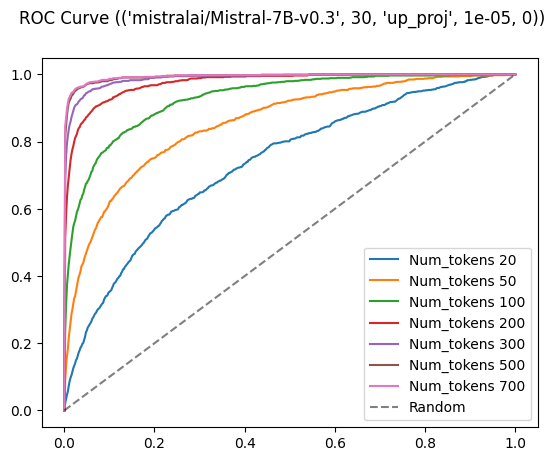

In [30]:
token_param = ('mistralai/Mistral-7B-v0.3', 30, 'up_proj', 1e-05, 0)
# token_param = ('meta-llama/Meta-Llama-3.1-8B', 30, 'down_proj', 0.0001, 4)
gen_param_tokens, data_param_tokens = generations_tokens[token_param], all_data_tokens[token_param]


grid_size = 500
fig, ax = plt.subplots()
data_param_tokens = {key: data_param_tokens[key] for key in sorted(data_param_tokens.keys())}
for key, data in data_param_tokens.items():
    grid, cdf = get_empirical_cdf(data['pvalue'], grid_size=grid_size)
    auc = get_auc(grid, cdf)
    print(f"AUC (Num_tokens {key}): {auc:.4f}")
    ax.plot(grid, cdf, label=f'Num_tokens {key}')

ax.plot(grid, grid, label='Random', linestyle='--', color='black', alpha=0.5)

ax.legend()
fig.suptitle(f'ROC Curve ({token_param})')
plt.show()


# Getting Alpaca Eval

In [58]:
def get_new_alpaca_eval_data(parent, good_models):
    """
    Given a parent directory, returns the data for the ALPaCA evaluation
    """
    alpaca_data = {}
    for root, dirs, file in os.walk(parent):

        if 'wins.json' in file:
            if len(root.split('/'))  > 1:
                if root.split('/')[1].startswith('._amlt'):
                # print(os.path.join(root, 'wins.json'))
                    with open(os.path.join(root, 'wins.json')) as f:
                        wins = json.load(f)
                    
                    path = wins['path']
                    run_name = os.path.basename(path)
                    ## Get index of df good_models such that the run_name column is equal to run_name
                    idx = good_models[good_models['run_name'] == run_name].index[0]
                    wins['good_models_idx'] = idx
                    watermarked_win_rate = wins['watermarked_wins'] / (wins['total'])
                    wins['watermarked_win_rate'] = watermarked_win_rate
                    
                    alpaca_data[root] = wins
                    

    # alpaca_data = {}
    # for dirname in os.listdir(parent):
    #     path = os.path.join(parent, dirname)
    #     with open(os.path.join(path, 'wins.json')) as f:
    #         wins = json.load(f)
    
    #     alpaca_data[dirname] = wins
    
    return alpaca_data


def get_old_alpaca_eval_data():
    """
    Returns the alpaca eval data in the directory of the old format
    """
    parent = '/home/blockadam/gaussian-watermarking/alpaca_win_rate/early'
    alpaca_data = {}
    for dirname in os.listdir(parent):
        if dirname in {'llama_meta-llama', 'mistral_mistralai'}:
            continue

        path = os.path.join(parent, dirname)
        with open(os.path.join(path, 'wins.json')) as f:
            wins = json.load(f)
        
        alpaca_data[dirname] = wins
    
    return alpaca_data

def get_baseline_alpaca_eval_data():
    """
    Returns the alpaca eval data in the directory of the old format
    """
    parent = '/home/blockadam/gaussian-watermarking/alpaca_win_rate'
    exp_name = '09-19-alpaca-generate-baseline'
    baseline_data = {}
    for dirname in os.listdir(parent):
        if exp_name in dirname:

            found = re.search('_see_(\d+)', dirname)
            seed = int(found.group(1))
            found = re.search('_wat_', dirname)
            model = dirname[found.end():-5]
            for root, dirs, file in os.walk(os.path.join(parent, dirname)):
                if 'wins.json' in file:
                    with open(os.path.join(root, 'wins.json')) as f:
                        wins = json.load(f)
                    wins['watermarked_win_rate'] = wins['watermarked_wins'] / (wins['total'])
                    if model not in baseline_data.keys():
                        baseline_data[model] = {}
                    baseline_data[model][seed] = wins
    
    return baseline_data




good_models = pd.read_csv('./good_watermarked_models.csv')

In [59]:
old_alpaca_data = get_old_alpaca_eval_data()
for override, wins in old_alpaca_data.items():

    watermarked_win_rate = wins['watermarked_wins'] / (wins['total'])
    print(f"{override} won {watermarked_win_rate:.4f}, totals {wins['total']}")

Llama-2-7b-hf@___@0@___@-1@___@none@___@weight@___@3e-06 won 0.4824, totals 796
Meta-Llama-3.1-8B@___@4@___@30@___@down_proj@___@weight@___@0.0001 won 0.4437, totals 791
Mistral-7B-v0.3@___@0@___@30@___@up_proj@___@weight@___@1e-05 won 0.4364, totals 786
Mistral-7B-v0.3@___@4@___@30@___@up_proj@___@weight@___@1e-05 won 0.4167, totals 792
Meta-Llama-3.1-8B@___@4@___@31@___@up_proj@___@weight@___@3e-05 won 0.4681, totals 784
Phi-3-mini-4k-instruct@___@16@___@31@___@down_proj@___@weight@___@3e-05 won 0.4435, totals 805


In [60]:
alpaca_data = get_new_alpaca_eval_data('alpaca_win_rate', good_models)
alpaca_data = {key:val for key,val in sorted(alpaca_data.items(), key=lambda x: x[1]['watermarked_win_rate'], reverse=True)}
for key, wins in alpaca_data.items():

    override = key.split('/')[-2].split('_')[1] + '/' + os.path.basename(key)

    
    idx = wins['good_models_idx']
    row = good_models.iloc[idx]

    auc = row['auc']
    laserized = row['laserized']
    print(f"{override} won {wins['watermarked_win_rate']:.4f}, totals {wins['total']}, auc {auc:.4f}, laserized {laserized}")



meta-llama/Meta-Llama-3.1-8B@___@0@___@28@@@gate_proj@@@weight@___@1e-4 won 0.5117, totals 770, auc 0.9311, laserized False
meta-llama/Meta-Llama-3.1-8B@___@0@___@29@@@down_proj@@@weight@___@3e-5 won 0.5045, totals 779, auc 0.9338, laserized False
meta-llama/Meta-Llama-3.1-8B@___@64@___@29@@@down_proj@@@weight@___@3e-5 won 0.4943, totals 787, auc 0.9338, laserized False
meta-llama/Meta-Llama-3.1-8B@___@64@___@28@@@gate_proj@@@weight@___@1e-4 won 0.4805, totals 770, auc 0.9311, laserized False
microsoft/Phi-3-mini-4k-instruct@___@0@___@28@@@gate_up_proj@@@weight@___@3e-4 won 0.4671, totals 805, auc 0.9044, laserized False
microsoft/Phi-3-mini-4k-instruct@___@0@___@28@@@gate_up_proj@@@weight@___@1e-3 won 0.4167, totals 804, auc 0.9614, laserized False
microsoft/Phi-3-mini-4k-instruct@___@0@___@28@@@down_proj@@@weight@___@1e-3 won 0.4161, totals 805, auc 0.9457, laserized False
mistralai/Mistral-7B-v0.3@___@0@___@28@@@up_proj@@@weight@___@3e-5 won 0.3799, totals 795, auc 0.9977, laserized

In [63]:
baseline_data['meta-llama_Llama-2-7b-hf'][1339]

{'param': 'llama_Base',
 'watermarked_wins': 284,
 'base_wins': 515,
 'total': 799,
 'path': '/home/blockadam/gaussian-watermarking/amlt/09-19-alpaca-generate-baseline/grid_09-19-alpaca-generate-baseline_see_1339_wat_meta-llama_Llama-2-7b-hf_____',
 'watermarked_win_rate': 0.35544430538172717}

In [61]:
baseline_data = get_baseline_alpaca_eval_data()

for model, model_data in baseline_data.items():

    win_rates = []
    for seed, wins in model_data.items():
        watermarked_win_rate = wins['watermarked_wins'] / (wins['base_model_wins'] + wins['watermarked_wins'])
        win_rates.append(watermarked_win_rate)
    
    print(f"{model} won {np.mean(win_rates):.4f} +/- {np.std(win_rates):.4f}, range: ({np.min(win_rates):.4f}, {np.max(win_rates):.4f})")



mistralai_Mistral-7B-v0.3 won 0.4862 +/- 0.0050, range: (0.4812, 0.4912)
meta-llama_Llama-2-7b-hf won 0.3920 +/- 0.0366, range: (0.3554, 0.4286)
meta-llama_Meta-Llama-3.1-8B won 0.3887 +/- 0.0474, range: (0.3413, 0.4361)
microsoft_Phi-3-mini-4k-instruct won 0.4422 +/- 0.0050, range: (0.4373, 0.4472)


# Gett good models  

In [86]:
for parent in [
    './amlt/09-04-watermark-mistral',
    './amlt/09-04-watermark-mistral-lm',
    './amlt/09-04-watermark-mistral-lowrank',
]:
    print(f"parent = '{parent}'")

parent = './amlt/09-04-watermark-mistral'
parent = './amlt/09-04-watermark-mistral-lm'
parent = './amlt/09-04-watermark-mistral-lowrank'


In [144]:

# parent = './amlt/llama-watermark'
# parent = './amlt/09-04-watermark-mistral'
# parent = './amlt/09-04-watermark-mistral-lm'
# parent = './amlt/09-04-watermark-llama'
# parent = './amlt/09-04-watermark-llama-lm'
# parent = './amlt/09-04-mistral-lowrank'
# parent ='./amlt/llama-watermark'
parent = './amlt/09-12-watermark-phi'





good_models = get_good_models([parent], auc_threshold=0.90, tolerance=0.005, min_prob=1e-20, grid_size=500, include_gsm8k=True)

No metrics found for ('-1_mlp_none_ran_0_r0', 3e-05)


In [145]:
overrides_mapping = {}
for dir in os.listdir(parent):
    with open(os.path.join(parent, dir, 'config.json'), 'r') as f:
        config = json.load(f)

    # base_model = config['tokenizer']
    base_model = 'microsoft/Phi-3-mini-4k-instruct'

    if '_lay_' in dir:
        layer = int(dir.split('_lay_')[-1].split('_')[0])
    elif '-lay_' in dir:
        layer = int(dir.split('-lay_')[-1].split('_')[0])
    if layer != -1:
        if '_mlp_' in dir:
            found = re.search('_mlp_(.*?)_r', dir)
            mlp_type = found.group(1)
    if '_ran_' in dir:
        rank = int(dir.split('_ran_')[-1].split('_')[0])
    else:
        rank = 0
    if '_var_' in dir:
        variance = float(dir.split('_var_')[-1])
    
    override = f"{base_model}@___@{rank}@___@{layer}@@@{mlp_type}@@@weight@___@{variance}"
    overrides_mapping[override] = dir







print(f"Num good models: {len(good_models)}\n")
overrides  = []
for key in good_models.keys():
    # print(f"{key}: AUC {good_models[key]:.4f}")
    override = get_watermark_overrides(key)
    overrides.append((override, good_models[key]))

sorted_overrides = sorted(overrides, key=lambda x: x[1], reverse=True)
for override, auc in sorted_overrides:
    run_name = overrides_mapping[override]
    exp_name = os.path.basename(parent)
    print(f"{override},{exp_name},{run_name},{auc:.4f},False")


Num good models: 3

microsoft/Phi-3-mini-4k-instruct@___@16@___@31@@@down_proj@@@weight@___@3e-05,09-12-watermark-phi,grid_09-12-watermark-phi_lay_31_mlp_down_proj_ran_16_var_3e-5,0.9567,False
microsoft/Phi-3-mini-4k-instruct@___@4@___@31@@@down_proj@@@weight@___@3e-05,09-12-watermark-phi,grid_09-12-watermark-phi_lay_31_mlp_down_proj_ran_4_var_3e-5,0.9562,False
microsoft/Phi-3-mini-4k-instruct@___@0@___@31@@@down_proj@@@weight@___@3e-05,09-12-watermark-phi,grid_09-12-watermark-phi_lay_31_mlp_down_proj_ran_0_var_3e-5,0.9551,False
